**Loading the dataset**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
 
%cd gdrive/My Drive/MajorProject
 
import cifar10
 
cifar10.data_path = "data/CIFAR-10/"
cifar10.maybe_download_and_extract()
 
class_names = cifar10.load_class_names()
images_train, cls_train, labels_train= cifar10.load_training_data()
images_test, cls_test, labels_test = cifar10.load_test_data()
 
x_train = images_train[0:45000]
y_train = labels_train[0:45000]
 
 
x_valid = images_train[45000:50000]
y_valid = labels_train[45000:50000]
 
x_test = images_test
y_test = labels_test

Mounted at /content/gdrive
/content/gdrive/My Drive/MajorProject
Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


**Import Statements**

In [2]:
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Input, Activation, Add, Dropout
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
import time
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

**Building the Model**

In [ ]:
def convolutional_block(X, f, s = 2):
    
    X_shortcut = X
 
    X = Conv2D(f / 4, (1,1), strides = (1,1), padding = "same", kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(f / 4, (3,3), strides = (s,s), padding = "same", kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
 
    X = Conv2D(f, (1,1), strides = (1,1), padding = "same", kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv2D(f, (1, 1), strides = (s,s), padding = "same", kernel_initializer = glorot_uniform(seed = 0))(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut) 
 
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
def ResidualNet():
    X_input = Input((32,32,3))

    X = Conv2D(64, (5,5), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X_input)
    X = Activation('relu')(X)
    X = BatchNormalization()(X)
    
    X = convolutional_block(X, 128)
    X = Dropout(0.15)(X)
    X = convolutional_block(X, 128, s = 1)
    X = Dropout(0.25)(X)

    X = convolutional_block(X, 256)
    X = Dropout(0.15)(X)
    X = convolutional_block(X, 256, s = 1)
    X = Dropout(0.25)(X)

    X = convolutional_block(X, 512)
    X = Dropout(0.15)(X)
    X = convolutional_block(X, 512, s = 1)
    X = Dropout(0.25)(X)

    X = convolutional_block(X, 1024)
    X = Dropout(0.15)(X)
    X = convolutional_block(X, 1024, s = 1)
    X = Dropout(0.25)(X)

    X = convolutional_block(X, 2048)
    X = Dropout(0.15)(X)
    X = convolutional_block(X, 2048, s = 1)
 
    X = Flatten()(X)
    X = Dense(1024, activation = 'relu', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = Dense(512, activation = 'relu', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = Dense(10, activation = 'softmax', kernel_initializer = glorot_uniform(seed = 0))(X)
    
    model = Model(inputs = X_input, outputs = X)
 
    return model

In [ ]:
model = ResidualNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         activation[0][0]                 
______________________________________________________________________________________________

**Augmentation**

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest')
it_train = datagen.flow(x_train, y_train, batch_size = 100)

**Training the Model**

In [ ]:
model = ResidualNet()
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 1.0e-4), metrics = ['accuracy'])
start = time.time()
model.fit_generator(it_train, epochs = 1, validation_data = (x_valid, y_valid))
end = time.time()

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


450/450 [==============================] - 106s 106ms/step - loss: 2.3422 - accuracy: 0.1361 - val_loss: 3.9389 - val_accuracy: 0.0950


In [ ]:
model = ResidualNet()
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 1.0e-4), metrics = ['accuracy'])
history = history = model.fit_generator(it_train, epochs = 200, validation_data = (x_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
450/450 [==============================] - 58s 104ms/step - loss: 2.3348 - accuracy: 0.1359 - val_loss: 4.1450 - val_accuracy: 0.0950
Epoch 2/200
450/450 [==============================] - 42s 94ms/step - loss: 2.1015 - accuracy: 0.2040 - val_loss: 3.4582 - val_accuracy: 0.1238
Epoch 3/200
450/450 [==============================] - 42s 94ms/step - loss: 2.0058 - accuracy: 0.2478 - val_loss: 2.7524 - val_accuracy: 0.1676
Epoch 4/200
450/450 [==============================] - 42s 94ms/step - loss: 1.9235 - accuracy: 0.2819 - val_loss: 2.5483 - val_accuracy: 0.2092
Epoch 5/200
450/450 [==============================] - 42s 94ms/step - loss: 1.8511 - accuracy: 0.3129 - val_loss: 2.0721 - val_accuracy: 0.2810
Epoch 6/200
450/450 [==============================] - 42s 93ms/step - loss: 1.7889 - accuracy: 0.3400 - val_loss: 1.8189 - val_accuracy: 0.3474
Epoch 7/200
450/450 [==============================] - 42s 94ms/step - loss: 1.7337 - accuracy: 0.3612 - val_loss: 1.7531 - val_a

**Saving the Model, History and Time**

In [ ]:
model.save('ResidualNetAug.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
np.save('ResidualNetAug_history.npy', history.history)

In [ ]:
with open('ResidualNetAug_time.pkl', 'wb') as f:
    pickle.dump(round(end - start), f)

**Training Analysis**

In [3]:
with open('ResidualNetAug_time.pkl', 'rb') as f: 
    time_loaded = pickle.load(f)
print("Time taken for training (1 epoch): ", time_loaded, "seconds")

Time taken for training (1 epoch):  107 seconds


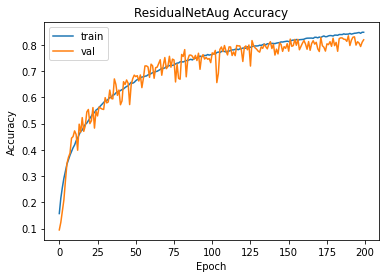

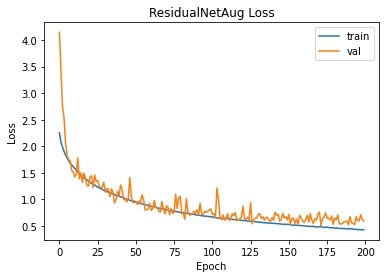

In [4]:
history_loaded = np.load('ResidualNetAug_history.npy', allow_pickle = 'TRUE').item()

plt.plot(history_loaded['accuracy'])
plt.plot(history_loaded['val_accuracy'])
plt.title('ResidualNetAug Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

plt.plot(history_loaded['loss'])
plt.plot(history_loaded['val_loss'])
plt.title('ResidualNetAug Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

**Testing Analysis**

In [5]:
model_loaded = load_model('ResidualNetAug.h5')
y_pred = model_loaded.predict(x_test)

In [6]:
def convert(y):
  return [np.argmax(i) for i in y]

y_pred_class = convert(y_pred)
y_true_class = convert(y_test)

**********Accuracy**********

 81.45 %


**********Classification Report***********

               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1000
           1       0.87      0.94      0.91      1000
           2       0.89      0.64      0.74      1000
           3       0.80      0.56      0.66      1000
           4       0.80      0.82      0.81      1000
           5       0.80      0.74      0.77      1000
           6       0.64      0.96      0.77      1000
           7       0.89      0.85      0.87      1000
           8       0.89      0.90      0.90      1000
           9       0.83      0.90      0.86      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



**********Confusion Matrix***********




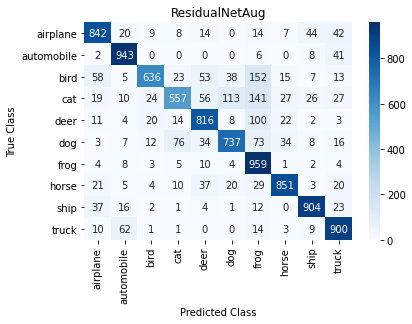

In [8]:
print("**********Accuracy**********\n\n", accuracy_score(y_true_class, y_pred_class) * 100, "%")
print("\n\n**********Classification Report***********\n\n", classification_report(y_true_class, y_pred_class))
print("\n\n**********Confusion Matrix***********\n\n")
sns.heatmap(confusion_matrix(y_true_class, y_pred_class), annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('ResidualNetAug')
plt.show()